Copyright 2019 The Google Research Authors.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Recovering Local Dynamics using RL-LIM with Synthetic Datasets

 * Jinsung Yoon, Sercan O Arik, Tomas Pfister, "RL-LIM: Reinforcement Learning-based Locally Interpretable Modeling", arXiv preprint arXiv:1909.12367 (2019) - https://arxiv.org/abs/1909.12367.
 
This notebook describes the user-guide of recovering local dynamics with synthetic datasets using "Reinforcement Learning based Locally Interpretable Modeling (RL-LIM)".

RL-LIM efficiently utilizes the small representational capacity of locally interpretable models by training with a small number of training samples that are determined to have the highest value contribution to the fitting of a locally interpretable model. In order to select these highest-value instances, we train instance-wise weight estimators (modeled with deep neural networks) using a reinforcement signal that quantifies the fidelity metric (i.e. how well does the model approximate the black-box model predictions). RL-LIM constructs locally interpretable models with the selected highest-value instances and outputs instance-wise explanations and interpretable predictions.

On real-world datasets it is challenging to directly evaluate the explanation quality of the locally interpretable models due to the absence of ground-truth explanations. Thus we initially focus on synthetic datasets (with known ground-truth explanations (local dynamics)) to directly evaluate how well the locally interpretable models can recover the underlying local dynamics.

##  Prerequisite

 * Clone https://github.com/google-research/google-research.git to the current directory.

In [1]:
import os
from git import Repo

# Current working directory
repo_dir = os.getcwd() + '/repo'

if not os.path.exists(repo_dir):
    os.makedirs(repo_dir)

# Clones github repository
if not os.listdir(repo_dir):
    git_url = "https://github.com/google-research/google-research.git"
    Repo.clone_from(git_url, repo_dir)

## Necessary packages and function calls

 * ridge: Ridge regression model used as an interpretable model.
 * load_synthetic_data: Data loader for synthetic datasets (Syn1, Syn2, Syn3).
 * rllim: RL-LIM class for training instance-wise weight estimator.
 * rllim_metrics: Evaluation metrics for the locally interpretable models in various metrics (fidelity and absolute weight difference (AWD)).

In [2]:
import numpy as np
from sklearn.linear_model import Ridge

# Sets current directory
os.chdir(repo_dir)

from rllim.data_loading import load_synthetic_data
from rllim import rllim
from rllim.rllim_metrics import awd_metric, fidelity_metrics, plot_result

## Data loading

 * Load training, probe and testing datasets and ground-truth explanations (local dynamics).
 * In this notebook, we generate synthetic training, probe, and testing datasets.
 
**outputs:**
 * x_train, y_train: Training features and labels.
 * x_probe, y_probe: Probe features and labels.
 * x_test, y_test: Testing features and labels.
 * c_test: Ground truth local dynamics of testing samples.

In [3]:
# Data name: 'Syn1' or 'Syn2' or 'Syn3' in this notebook

# X ~ N(0, I)
# Syn1: Y = X_0 + 2 X_1 if X_10 < 0             &  Y = X_2 + 2 X_3 if X_10 >= 0
# Syn2: Y = X_0 + 2 X_1 if X_10 + e^{X_11} < 1  &  Y = X_2 + 2 X_3 if X_10 + e^{X_11} >= 1
# Syn3: Y = X_0 + 2 X_1 if X_10 + (X_11)^3 < 0  &  Y = X_2 + 2 X_3 if X_10 + (X_11)^3 >= 0 

data_name = 'Syn1'

# The number of training, probe and testing samples
dict_no = dict()
dict_no['train'] = 1000
dict_no['probe'] = 100
dict_no['test'] = 1000

# The number of dimensions
dict_no['dim'] = 11

# Random seed
seed = 0

# Loads data
x_train, y_train, x_probe, y_probe, x_test, y_test, c_test = load_synthetic_data(data_name, dict_no, seed)

print('Finished data loading.')

Finished data loading.


## Step 0 & Step 1:

In this notebook, we skip Step 0 and Step 1 (of RL-LIM) because we treat y_train, y_probe, and y_test as the predictions of the pre-trained black-box model. We directly use the ground truth function as the black-box model and focus on how well locally interpretable modeling can capture the local dynamics.

 * Step 0: Black-box model training.
 * Step 1: Auxiliary dataset construction.

## Step 2: Interpretable baseline training

To improve the stability of the instance-wise weight estimator training, an interpretable baseline model is observed to be beneficial. We use a globally interpretable model (in this notebook, we use Ridge regression) optimized to replicate the predictions of the black-box model.

1. **Input**: 
 * locally interpretable model: Ridge regression (we can switch this to linear regression). The model must have fit, predict (for regression) or predict_proba (for classification), intercept_ and coef_  as the methods.
 
 
2. **Output**:
 * Trained interpretable baseline model: Function that tries to replicate the predictions of the black-box model using globally interpretable model.

In [4]:
# Defines baseline
baseline = Ridge(alpha=1)

# Trains interpretable baseline model
baseline.fit(x_train, y_train)

print('Finished interpretable baseline training.')

Finished interpretable baseline training.


## Step 3: Trains instance-wise weight estimator

We train an instance-wise weight estimator using training dataset (x_train, y_train) and probe dataset (x_probe, y_probe) using reinforcement learning.

1. **Input**: 
 * Network parameters: Set network parameters of instance-wise weight estimator.
 * Locally interpretable model: Ridge regression (we can switch this to linear regression). The model must have fit, predict (for regression) or predict_proba (for classification), intercept_ and coef_ as the methods.
 
 
2. **Output**:
 * Instancewise weight estimator: Function that uses training set and a testing sample as inputs to estimate weights for each training sample to construct locally interpretable model for the testing sample.

In [5]:
# Instance-wise weight estimator network parameters
parameters = dict()
parameters['hidden_dim'] = 100
parameters['iterations'] = 2000
parameters['num_layers'] = 5
parameters['batch_size'] = 900
parameters['batch_size_inner'] = 10
parameters['lambda'] = 1.0

# Checkpoint file name
checkpoint_file_name = './tmp/model.ckpt'

# Defines locally interpretable model
interp_model = Ridge(alpha=1)

# Initializes RL-LIM
rllim_class = rllim.Rllim(x_train, y_train, x_probe, y_probe, parameters, interp_model, baseline, checkpoint_file_name)

# Trains RL-LIM
rllim_class.rllim_train()

print('Finished instance-wise weight estimator training.')

## Output functions
# Instance-wise weight estimator for x_test[0, :]
dve_out = rllim_class.instancewise_weight_estimator(x_train, y_train, x_test[0, :])

# Interpretable predictions (test_y_fit) and instance-wise explanations (test_coef) for x_test[0, :]
test_y_fit, test_coef = rllim_class.rllim_interpreter(x_train, y_train, x_test[0, :], interp_model)

print('Finished instance-wise weight estimations, interpretable predictions, and local explanations.')


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.


100%|██████████| 2000/2000 [04:09<00:00,  8.64it/s]


Finished instance-wise weight estimator training.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./tmp/model.ckpt
INFO:tensorflow:Restoring parameters from ./tmp/model.ckpt


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

Finished instance-wise weight estimations, interpretable predictions, and local explanations.


## Step 4: Interpretable inference

Unlike Step 3 (training instance-wise weight estimator), we use a fixed instance-wise weight estimator (without the sampler and interpretable baseline) and merely fit the locally interpretable model at inference. Given the test instance, we obtain the selection probabilities from the instance-wise weight estimator, and using these as the weights, we fit the locally interpretable model via weighted optimization. 

1. **Input**: 
 * Locally interpretable model: Ridge regression (we can switch this to linear regression). The model must have fit, predict (for regression) or predict_proba (for classification), intercept_ and coef_ as the methods.
 
 
2. **Output**:
 * Instance-wise explanations (test_coef): Estimated local dynamics for testing samples using trained locally interpretable model.
 * Interpretable predictions (test_y_fit): Local predictions for testing samples using trained locally interpretable model.

In [6]:
# Trains locally interpretable models and output instance-wise explanations (test_coef) and
# interpretable predictions (test_y_fit) 
test_y_fit, test_coef = rllim_class.rllim_interpreter(x_train, y_train, x_test, interp_model)

print('Finished interpretable predictions and local explanations.')

INFO:tensorflow:Restoring parameters from ./tmp/model.ckpt


100%|██████████| 1000/1000 [00:04<00:00, 225.73it/s]

Finished interpretable predictions and local explanations.


## Evaluation

We use two metrics (fidelity and average weight difference (AWD)) to evaluate the locally interpretable models.

 * Fidelity: Difference between black-box model predictions (y_test_hat) and interpretable predictions (test_y_fit). In this notebook, we use Mean Absolute Error (MAE) as the metric.
 * Average Weight Difference (AWD): Mean absolute difference between ground truth local dynamics (test_c) and instance-wise explanations (test_coef).

In [7]:
# Fidelity
mae = fidelity_metrics (y_test, test_y_fit, metric='mae')
print('fidelity of RL-LIM in terms of MAE: ' + str(np.round(mae, 4)))

# AWD
awd = awd_metric (c_test, test_coef)
print('AWD of RL-LIM: ' + str(np.round(awd, 4)))

fidelity of RL-LIM in terms of MAE: 0.5137
AWD of RL-LIM: 0.183


### 1. Fidelity plot

We visualize the fidelity (in terms of MAE) of the testing samples based on the distance from the boundary where the local dynamics change (in percentile).

 * x-axis: Distance from the boundary where the local dynamics change (in percentile).
 * y-axis: Fidelity (in terms of MAE).

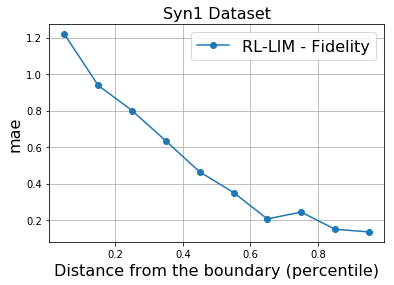

In [8]:
# Reports fidelity plot
plot_result(x_test, data_name, y_test, test_y_fit, c_test, test_coef, metric='mae', criteria='Fidelity')

### 2. AWD plot

We visualize the AWD of the testing samples based on the distance from the boundary where the local dynamics change (in percentile).

 * x-axis: Distance from the boundary where the local dynamics change (in percentile).
 * y-axis: AWD.

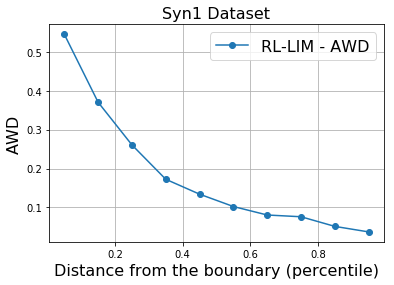

In [9]:
# Reports AWD plot
plot_result(x_test, data_name, y_test, test_y_fit, c_test, test_coef, metric='mae', criteria='AWD')